<a href="https://colab.research.google.com/github/Skalwalker/AntiMoneyLaundering/blob/main/anti_money_laundering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Transactions for Anti Money Laundering

The project is based on the analysis of the «IBM Transactions for Anti Money Laundering» dataset published on [Kaggle](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml) and released under the Community Data License Agreement – Sharing – Version 1.0. This dataset contains several CSV files, each having a different combination of data size and amount of illicit transactions.

## About

This project is a partial requisite for completing the courses of "Algorithms for massive datasets" and "Statistical methods for ML" on the masters degree computer science program from Università degli Studi di Milano.

- **Author:** Renato Avellar Nobre
- **Matriculation Number:** 984405
- **Exam Project Year:** 22/23

### Disclaimer

"I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study."


# Overview

The task is to implement a system which predicts whether or not a transaction is illicit, using the attribute "Is Laundering" as a label to be predicted. Classification should be done exploiting a random forest, organizing the project as follows.

1. A sequential implementation (from scratch) of the learning algorithm for a decision tree should be provided, and tested using one or more subsets of the dataset which can be loaded in main memory.

2. A mock-up code that uses spark in order to consider a dataset and processes it in order to distribute the creation of the single trees in a random forest should be proposed. In particular, the construction of each tree should be done by providing different data to each worker, both subsampling the number of rows (i.e., labeled objects) and columns (i.e., attributes) in the overall dataset. Concerning the first kind of subsampling, you might possibly consider introducing the so-called bootstrap sampling, in which the labeled objects are sampled with replacement and therefore a same object can occur more than once in the resulting dataset. It is not required to distribute the creation of a single decision tree: for this task you are free to use the implementation provided in point 1, as well as the implementation already available in scikit-learn.




## Before we start...

Please upload the JSON file of your Kaggle API by executing the code below. Kaggle API JSON files can be generated on your [Kaggle user profile setting](https://www.kaggle.com/settings)

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


Also, choose whether to run or skip the Exploratory Data Analysis Process and Feature Vizualisation.


*   **Processing** may take a while
*   **Skipping** will remove previous outputs



In [2]:
skip_eda = False
skip_feature_viz = False

# Setup

In [3]:
import os

data_folders = ["01_raw"]

try:
    os.makedirs("data", exist_ok = True)
    [os.makedirs("data/" + folder_name, exist_ok = True) for folder_name in data_folders]
    print("Directories created successfully")
except OSError as error:
    print(f"Directories can not be created: {error}")


Directories created successfully


## Fetching Files from Kaggle

In [4]:
!pip install kaggle
!kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml

100% 7.42G/7.42G [04:38<00:00, 20.4MB/s]
100% 7.42G/7.42G [04:38<00:00, 28.6MB/s]


In [5]:
!unzip ibm-transactions-for-anti-money-laundering-aml.zip -d ./data/01_raw/ -x "LI*" "HI-Large*"

Archive:  ibm-transactions-for-anti-money-laundering-aml.zip
  inflating: ./data/01_raw/HI-Medium_Patterns.txt  
  inflating: ./data/01_raw/HI-Medium_Trans.csv  
  inflating: ./data/01_raw/HI-Small_Patterns.txt  
  inflating: ./data/01_raw/HI-Small_Trans.csv  


In [6]:
!rm ibm-transactions-for-anti-money-laundering-aml.zip
!rm ./data/01_raw/*.txt

## Installations

In [7]:
!pip install --upgrade ipykernel
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.23.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=3a925a28c481fb33f8abb41a2a89a90d29e5a0f010880bc8aaef466b7940dd5b
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully 

## Imports

In [8]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler, FeatureHasher
from pyspark.sql.functions import (col, sum, lag, round, lit, to_timestamp, countDistinct, hour,
                                   dayofmonth, dayofmonth, minute, date_format, to_date, when,
                                   count, row_number, coalesce, unix_timestamp, max)

from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def skip(line, cell=None):

    if eval(line):
        return

    get_ipython().ex(cell)

## Setting Up PySpark

In [9]:
if 'spark' in vars():
  spark.stop()

cores = multiprocessing.cpu_count()
instances = cores

spark = SparkSession.builder \
          .appName("MoneyLaundering") \
          .config("spark.driver.memory", "3g") \
          .config("spark.executor.memory", "4g") \
          .config("spark.executor.instances", cores) \
          .config("spark.executor.cores", cores//instances) \
          .config("spark.sql.shuffle.partitions", cores) \
          .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
          .config("spark.sql.execution.arrow.enabled", "true") \
          .getOrCreate()

spark.sparkContext.setLogLevel("OFF")

In [10]:
for x in spark.sparkContext.getConf().getAll():
  print(f"{x[0].replace('.', ' ').capitalize()}: {x[1]}")

Spark app submittime: 1688289257323
Spark app id: local-1688289260391
Spark sql execution arrow enabled: true
Spark driver port: 36931
Spark app starttime: 1688289257732
Spark executor memory: 4g
Spark app name: MoneyLaundering
Spark executor id: driver
Spark sql shuffle partitions: 2
Spark driver extrajavaoptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.ca

# 0. Data Engineering Preparation

In [11]:
!ls -l --block-size=GB ./data/01_raw/

total 4GB
-rw-r--r-- 1 root root 4GB Feb 28 12:08 HI-Medium_Trans.csv
-rw-r--r-- 1 root root 1GB Feb 28 12:12 HI-Small_Trans.csv


## Raw Data

The raw layer is the starting point of the data pipeline and includes the sourced data model(s) that should never be altered. It serves as the single source of truth for all subsequent work. Typically, these data models are untyped, such as CSV files.

* We never mutate the data here, only work on copies.



In [12]:
# High Ilicity Datasets
hi_small_df = spark.read.csv("./data/01_raw/HI-Small_Trans.csv", header=True)
hi_medium_df = spark.read.csv("./data/01_raw/HI-Medium_Trans.csv", header=True)

In [13]:
hi_small_df.columns

['Timestamp',
 'From Bank',
 'Account2',
 'To Bank',
 'Account4',
 'Amount Received',
 'Receiving Currency',
 'Amount Paid',
 'Payment Currency',
 'Payment Format',
 'Is Laundering']

In [14]:
hi_small_df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)



In [15]:
# Verify if all columns are equal
hi_cols_equal = (hi_small_df.columns == hi_medium_df.columns)

print(f"Are all Small and Medium Dataset cols the same? {hi_cols_equal}")

Are all Small and Medium Dataset cols the same? True


In [16]:
hi_small_df.show()

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:20|      010|8000EBD30|    010|8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:20|    03208|8000F4580|    001|8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|
|2022/09/01 00:00|    03209|8000F4670|  03209|8000F4670|       14675.57|         US Dollar|   14675.57|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:02|      012|8000F5030|    012|8000F5030|        2806.97|         US Dollar|    2806.

In [17]:
null_counts = hi_small_df.select([sum(col(column).isNull().cast("integer")).alias(column) for column in hi_small_df.columns])
null_counts.show()

+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|        0|        0|       0|      0|       0|              0|                 0|          0|               0|             0|            0|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+



## Intermediate Data

In practice the intermediate layer only needs to be a typed mirror of the raw layer still within the ‘source’ data model

* Once the intermediate layer exists, you never have to touch the raw layer and we eliminate the risks associated with mutating the original data.

* Profiling, EDA and any data quality assessments should be performed at this point.

* Cleaning column names, parsing dates and dropping completely null columns are other ‘transformations’ commonly performed at this stage.

In [18]:
schema = StructType([
    StructField("Timestamp", StringType(), nullable=False),
    StructField("From Bank", IntegerType(), nullable=False),
    StructField("Account2", StringType(), nullable=False),
    StructField("To Bank", IntegerType(), nullable=False),
    StructField("Account4", StringType(), nullable=False),
    StructField("Amount Received", FloatType(), nullable=False),
    StructField("Receiving Currency", StringType(), nullable=False),
    StructField("Amount Paid", FloatType(), nullable=False),
    StructField("Payment Currency", StringType(), nullable=False),
    StructField("Payment Format", StringType(), nullable=False),
    StructField("Is Laundering", IntegerType(), nullable=False),
])

In [19]:
hi_small_df = spark.read.csv("./data/01_raw/HI-Small_Trans.csv", header=True, schema=schema)
hi_medium_df = spark.read.csv("./data/01_raw/HI-Medium_Trans.csv", header=True, schema=schema)

# Fixing Timestamp
def fix_timestamp(df):
  format = "yyyy/MM/dd HH:mm"
  df = df.withColumn("Timestamp2",to_timestamp("Timestamp", format=format).cast('timestamp'))
  df = df.drop("Timestamp")
  df = df.withColumnRenamed("Timestamp2", "Timestamp")
  return df

hi_small_df = fix_timestamp(hi_small_df)
hi_medium_df = fix_timestamp(hi_medium_df)

In [20]:
hi_small_df.printSchema()

root
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: float (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: float (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)



In [21]:
hi_small_df.show()

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|       10|8000EBD30|     10|8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|2022-09-01 00:20:00|
|     3208|8000F4580|      1|8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|2022-09-01 00:20:00|
|     3209|8000F4670|   3209|8000F4670|       14675.57|         US Dollar|   14675.57|       US Dollar|  Reinvestment|            0|2022-09-01 00:00:00|
|       12|8000F5030|     12|8000F5030|        2806.97|         US Dollar|    2806

### Exploratory Data Analysis
---

For simplicity and time saving we will analyse only the small Datasets

**Insights:**


* Reinvestment doesn't appear to have money laundry
* Laundering occur in self transactions in few cases
* Accounts are identifiers of the transaction
* There is no money laundring happening in between currencies. Which mean we can keep only one variable for Receiving Currency and Payment Currency, and Amount Received and Amount Paid


**Possible Features:**

* Self Transaction flag
* Time of the day transaction
* Day of the month transaction?
* Number of transactions in the day


In [22]:
%%skip $skip_eda
small_df = hi_small_df

In [23]:
%%skip $skip_eda
# Get the label distribution in the dataset
small_df.groupBy("Is Laundering").count().show()

+-------------+-------+
|Is Laundering|  count|
+-------------+-------+
|            0|5073168|
|            1|   5177|
+-------------+-------+



In [24]:
%%skip $skip_eda
# Split the dataset into Legit and Laundering Transactions to analyze the feature in each case
small_laundering_df = small_df.filter(small_df["Is Laundering"] == 1)
small_legit_df = small_df.filter(small_df["Is Laundering"] == 0)

float_columns = ["Amount Received", "Amount Paid"]
small_laundering_df.select(float_columns).describe().show()
small_legit_df.select(float_columns).describe().show()

+-------+--------------------+--------------------+
|summary|     Amount Received|         Amount Paid|
+-------+--------------------+--------------------+
|  count|                5177|                5177|
|   mean| 3.613531071586281E7| 3.613531071586281E7|
| stddev|1.5279186868932502E9|1.5279186868932502E9|
|    min|            0.003227|            0.003227|
|    max|        8.4853146E10|        8.4853146E10|
+-------+--------------------+--------------------+

+-------+--------------------+-------------------+
|summary|     Amount Received|        Amount Paid|
+-------+--------------------+-------------------+
|  count|             5073168|            5073168|
|   mean|   5957962.500255194|  4477000.057857775|
| stddev|1.0365634624133482E9|8.688463078849382E8|
|    min|              1.0E-6|             1.0E-6|
|    max|       1.04630236E12|      1.04630236E12|
+-------+--------------------+-------------------+



In [25]:
%%skip $skip_eda

# Distinct Ilegal Accounts
small_laundering_df.select(countDistinct("Account2")).first()[0]

In [26]:
%%skip $skip_eda

# Analysis of Ilegality through payment formats
small_laundering_df.groupBy("Payment Format").count().show()
small_legit_df.groupBy("Payment Format").count().show()

+--------------+-----+
|Payment Format|count|
+--------------+-----+
|           ACH| 4483|
|       Bitcoin|   56|
|        Cheque|  324|
|   Credit Card|  206|
|          Cash|  108|
+--------------+-----+

+--------------+-------+
|Payment Format|  count|
+--------------+-------+
|           ACH| 596314|
|       Bitcoin| 146035|
|  Reinvestment| 481056|
|        Cheque|1864007|
|   Credit Card|1323118|
|          Cash| 490783|
|          Wire| 171855|
+--------------+-------+



In [27]:
%%skip $skip_eda

# Show ilegal transactions are made for the same account
small_laundering_df.filter(small_laundering_df["Account2"] == small_laundering_df["Account4"]).show()

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|    48309|811C599A0|  48309|811C599A0|       48649.42|       Saudi Riyal|   48649.42|     Saudi Riyal|           ACH|            1|2022-09-04 05:03:00|
|    15231|80266F880|  15231|80266F880|       14998.24|              Euro|   14998.24|            Euro|           ACH|            1|2022-09-01 14:04:00|
|    15231|80266F880|  15231|80266F880|        4895.52|              Euro|    4895.52|            Euro|           ACH|            1|2022-09-03 19:55:00|
|   150240|812D22980| 150240|812D22980|       71726.48|       Saudi Riyal|   71726

In [28]:
%%skip $skip_eda

# Show ilegal transactions difference in payment ammount
small_laundering_df.filter(small_laundering_df["Amount Paid"] != small_laundering_df["Amount Received"]).show()

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [29]:
%%skip $skip_eda

# Show ilegal transactions in different currencies
small_laundering_df.filter(small_laundering_df["Receiving Currency"] != small_laundering_df["Payment Currency"]).show()

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [30]:
%%skip $skip_eda

small_laundering_df.groupBy("Receiving Currency").count().show()
small_laundering_df.groupBy("Payment Currency").count().show()

+------------------+-----+
|Receiving Currency|count|
+------------------+-----+
|         US Dollar| 1912|
|              Euro| 1372|
|              Yuan|  184|
|               Yen|  155|
|       Swiss Franc|  193|
|             Rupee|  167|
| Australian Dollar|  127|
|       Saudi Riyal|  374|
|      Mexican Peso|   92|
|          UK Pound|  132|
|       Brazil Real|   57|
|           Bitcoin|   56|
|   Canadian Dollar|  128|
|            Shekel|   95|
|             Ruble|  133|
+------------------+-----+

+-----------------+-----+
| Payment Currency|count|
+-----------------+-----+
|        US Dollar| 1912|
|             Euro| 1372|
|             Yuan|  184|
|              Yen|  155|
|      Swiss Franc|  193|
|            Rupee|  167|
|Australian Dollar|  127|
|      Saudi Riyal|  374|
|     Mexican Peso|   92|
|         UK Pound|  132|
|      Brazil Real|   57|
|          Bitcoin|   56|
|  Canadian Dollar|  128|
|           Shekel|   95|
|            Ruble|  133|
+-----------------

**Account-related analysis:**

* Account activity: Unusually high transaction activity or a large number of accounts linked to a particular entity may indicate suspicious behavior.

* Create features that capture the frequency and volume of transactions from both the "From Account" and "To Account."
* Including the account identifiers as features may introduce data leakage because the model can learn patterns specific to  accounts.
* The destination bank appears to have strong predictive power in this case.
* The destination accounts as well, it appears to be accounts never used before.

In [31]:
%%skip $skip_eda

small_legit_df.where(small_laundering_df["Account2"] == "10042B6A8").show(10)

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [32]:
%%skip $skip_eda

small_laundering_df.where(small_laundering_df["Account2"] == "10042B6A8").show(10)

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [33]:
%%skip $skip_eda

receinving_accs = ["806242CD0", "806573660", "80E95DAC0", "801F02820", "805F99460",
                   "80AEDE4A0", "80B2862D0", "816325220", "8041E5A30", "8007D19B0"]
small_laundering_df.where(small_laundering_df["Account2"].isin(receinving_accs)).show(10)

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



**Time-related analysis:**

* Extract day of the week: Convert the timestamp into a day of the week feature. Illegal transactions may exhibit certain patterns or anomalies depending on the day of the week.

* Extract hour of the day: Convert the timestamp into an hour of the day feature. Similar to the day of the week, certain hours may be more associated with illegal activities.

In [34]:
%%skip $skip_eda

weekly_laundering = small_laundering_df.withColumn("Weekday", date_format('Timestamp', 'EEEE')).groupBy("Weekday").count().cache()
weekly_legit = small_legit_df.withColumn("Weekday", date_format('Timestamp', 'EEEE')).groupBy("Weekday").count().cache()
weekly_laundering.join(weekly_legit.withColumnRenamed("count", "count2"), "Weekday"). \
                 withColumn("Laundering Rate", col("count") / col("count2")). \
                 withColumn("Laundering Rate", col("Laundering Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Laundering Rate").desc()). \
                 show()

+---------+-----+-------+---------------+
|  Weekday|count| count2|Laundering Rate|
+---------+-----+-------+---------------+
|   Sunday|  647| 207190|   0.0031227376|
| Saturday|  848| 414882|   0.0020439547|
|   Monday|  641| 482290|   0.0013290759|
|  Tuesday|  637| 481636|   0.0013225756|
|Wednesday|  567| 482305|   0.0011756046|
|   Friday|  948|1408014|   0.0006732888|
| Thursday|  889|1596851|   0.0005567207|
+---------+-----+-------+---------------+



In [35]:
%%skip $skip_eda

hourly_laundering = small_laundering_df.withColumn("Hour", hour('Timestamp')).groupBy("Hour").count().cache()
hourly_legit = small_legit_df.withColumn("Hour", hour('Timestamp')).groupBy("Hour").count().cache()
hourly_laundering.join(hourly_legit.withColumnRenamed("count", "count2"), "Hour"). \
                 withColumn("Hourly Rate", col("count") / col("count2")). \
                 withColumn("Hourly Rate", col("Hourly Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Hourly Rate").desc()). \
                 show()

+----+-----+------+------------+
|Hour|count|count2| Hourly Rate|
+----+-----+------+------------+
|  12|  336|192636|0.0017442223|
|  16|  311|193096|0.0016105978|
|  11|  295|193205|0.0015268756|
|  13|  292|192229|0.0015190216|
|  14|  279|192508|0.0014492904|
|  15|  263|194608|0.0013514347|
|   8|  258|192663|0.0013391258|
|  17|  257|192897|0.0013323172|
|  18|  255|193066|0.0013207919|
|  10|  234|192995|0.0012124666|
|  19|  231|192593|0.0011994205|
|   9|  217|192735|0.0011258983|
|   6|  207|194249|0.0010656426|
|   7|  195|193141|0.0010096251|
|   5|  188|193712|0.0009705129|
|   2|  165|192978|0.0008550197|
|  21|  154|192038|0.0008019246|
|   4|  154|193012|0.0007978779|
|   1|  152|193576|0.0007852213|
|  23|  150|193195|0.0007764176|
+----+-----+------+------------+
only showing top 20 rows



In [36]:
%%skip $skip_eda

daily_laundering = small_laundering_df.withColumn("Date", dayofmonth('Timestamp')).groupBy("Date").count().cache()
daily_legit = small_legit_df.withColumn("Date", dayofmonth('Timestamp')).groupBy("Date").count().cache()
daily_laundering.join(daily_legit.withColumnRenamed("count", "count2"), "Date"). \
                 withColumn("Daily Rate", col("count") / col("count2")). \
                 withColumn("Daily Rate", col("Daily Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Daily Rate").desc()). \
                 show()

+----+-----+-------+------------+
|Date|count| count2|  Daily Rate|
+----+-----+-------+------------+
|  18|    8|      3|2.6666666667|
|  17|   15|      8|1.8750000000|
|  15|   28|     18|1.5555555556|
|  12|  170|    111|1.5315315315|
|  11|  232|    164|1.4146341463|
|  14|   70|     51|1.3725490196|
|  13|  106|     78|1.3589743590|
|  16|   26|     20|1.3000000000|
|  10|  442| 207883|0.0021261960|
|   4|  407| 207023|0.0019659651|
|   3|  391| 206991|0.0018889710|
|   8|  539| 482234|0.0011177146|
|   6|  531| 481558|0.0011026709|
|   7|  497| 482254|0.0010305772|
|   5|  471| 482179|0.0009768157|
|   9|  514| 653953|0.0007859892|
|   2|  408| 754041|0.0005410846|
|   1|  322|1114599|0.0002888931|
+----+-----+-------+------------+



## Feature Data


The feature data layer comprises an analytics-specific data model that includes a collection of features defined based on the primary data. In practical terms, this layer represents both the independent variables and the target variable, which serve as the foundation for exploring and applying machine learning techniques.

In [37]:
def create_time_features(ds):
  ds = ds.withColumn("Hour", hour('Timestamp'))
  ds = ds.withColumn("Day", dayofmonth('Timestamp'))
  ds = ds.withColumn("Minute", minute('Timestamp'))
  ds = ds.withColumn("Date", to_date('Timestamp'))
  ds = ds.withColumn("Weekday", date_format('Timestamp', 'EEEE'))
  return ds

def create_self_payment_feature(ds):
  ds = ds.withColumn("SelfPayment", when(col("Account2") == col("Account4"), 1).otherwise(0))
  return ds

def clean_payment_format(ds):
  ds = ds.where(col("Payment Format") != "Reinvestment")
  return ds

def create_currency_features(ds):
  ds = ds.withColumn("SameCurrencyTransaction", when(col("Receiving Currency") == col("Payment Currency"), 1).otherwise(0))
  ds = ds.drop("Payment Currency")
  ds = ds.withColumnRenamed("Receiving Currency", "Currency")
  return ds

def create_ammount_features(ds):
  ds = ds.withColumn("AmtReceivedRatio",  col("Amount Received") / col("Amount Paid"))
  ds = ds.drop("Amount Paid")
  ds = ds.withColumnRenamed("Amount Received", "AmtReceived")
  return ds

def trans_by_acc_features(ds):
  # Total Transaction Ammount in Hour
  temp = ds.groupBy("Account2", "Hour").agg(count("*").alias("AccTransAmtInHour")).cache()
  ds = ds.join(temp, on=["Account2", "Hour"], how="left")
  # Total Transaction Ammount in Day
  temp = ds.groupBy("Account2", "Day").agg(count("*").alias("AccTransAmtInDay")).cache()
  ds = ds.join(temp, on=["Account2", "Day"], how="left")

  # Transaction Number by the Account in the Hour
  w = Window.partitionBy(ds["Account2"], ds["Date"], ds["Hour"]).orderBy(ds["Minute"])
  ds = ds.withColumn('AccTransNumByHour', row_number().over(w))
  # Transaction Number by the Account in the Day
  w = Window.partitionBy(ds["Account2"], ds["Date"]).orderBy(ds["Hour"], ds["Minute"])
  ds = ds.withColumn('AccTransNumByDay', row_number().over(w))

  # Time in mins since last transaction
  w = Window.partitionBy(ds["Account2"]).orderBy(ds["Timestamp"])
  ds = ds.withColumn("MinsSinceLastTrans", coalesce(round((unix_timestamp("Timestamp") - lag(unix_timestamp("Timestamp"), 1).over(w))/60), lit(0)))

  return ds

def receiving_acc_features(ds):
  # Total Transaction Ammount to same account in Hour
  temp = ds.groupBy("Account2", "Account4", "Hour").agg(count("*").alias("HourAccTransAmtToSameAcc")).cache()
  ds = ds.join(temp, on=["Account2", "Account4", "Hour"], how="left")
  # Total Transaction Ammount to same account in Day
  temp = ds.groupBy("Account2", "Account4", "Day").agg(count("*").alias("DayAccTransAmtToSameAcc")).cache()
  ds = ds.join(temp, on=["Account2", "Account4", "Day"], how="left")

  # Transaction Number by the Account to same account in the Hour
  w = Window.partitionBy(ds["Account2"], ds["Account4"], ds["Date"], ds["Hour"]).orderBy(ds["Minute"])
  ds = ds.withColumn('HourAccTransNumToSameAcc', row_number().over(w))
  # Transaction Number by the Account to same account in the Day
  w = Window.partitionBy(ds["Account2"], ds["Account4"], ds["Date"]).orderBy(ds["Hour"], ds["Minute"])
  ds = ds.withColumn('DayAccTransNumToSameAcc', row_number().over(w))

  # Time in mins since last transaction to same account
  w = Window.partitionBy(ds["Account2"], ds["Account4"]).orderBy(ds["Timestamp"])
  ds = ds.withColumn("MinsSinceLastTransToSameAcc", coalesce(round((unix_timestamp("Timestamp") - lag(unix_timestamp("Timestamp"), 1).over(w))/60), lit(0)))

  # Amt of Transactions to Acc4 in Last Hour
  w = Window.partitionBy(ds['Account4'], ds["Date"], ds["Hour"]).orderBy('Minute')
  ds = ds.withColumn('HourDestAccTransReceived', count('Account2').over(w))

  # Amt of Transactions to Acc4 in Last Day
  w = Window.partitionBy(ds['Account4'], ds["Date"]).orderBy(ds["Hour"], ds["Minute"])
  ds = ds.withColumn('DayDestAccTransReceived', count('Account2').over(w))

  return ds

def cleanup(ds):
   ds = ds.drop("Date")
   ds = ds.drop("Timestamp")
   ds = ds.drop("Account2")
   ds = ds.drop("Account4")
   return ds

In [38]:
%%skip $skip_feature_viz
small_df = hi_small_df

In [39]:
%%skip $skip_feature_viz
small_df = create_time_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+----+---+------+----------+--------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+----+---+------+----------+--------+
|       10|8000EBD30|     10|8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|2022-09-01 00:20:00|   0|  1|    20|2022-09-01|Thursday|
|     3208|8000F4580|      1|8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|2022-09-01 00:20:00|   0|  1|    20|2022-09-01|Thursday|
|     3209|8000F4670|   3209|8000F4670|       14675.57|

In [40]:
%%skip $skip_feature_viz
small_df = create_self_payment_feature(small_df)
small_df = clean_payment_format(small_df)
small_df.groupBy("Payment Format").count().show()
small_df.groupBy("SelfPayment").count().show()

+--------------+-------+
|Payment Format|  count|
+--------------+-------+
|           ACH| 600797|
|       Bitcoin| 146091|
|        Cheque|1864331|
|   Credit Card|1323324|
|          Cash| 490891|
|          Wire| 171855|
+--------------+-------+

+-----------+-------+
|SelfPayment|  count|
+-----------+-------+
|          0|4487133|
|          1| 110156|
+-----------+-------+



In [41]:
%%skip $skip_feature_viz
small_df = create_currency_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+---------------+---------+-----------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+
|From Bank| Account2|To Bank| Account4|Amount Received| Currency|Amount Paid|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|
+---------+---------+-------+---------+---------------+---------+-----------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+
|     3208|8000F4580|      1|8000F5340|           0.01|US Dollar|       0.01|        Cheque|            0|2022-09-01 00:20:00|   0|  1|    20|2022-09-01|Thursday|          0|                      1|
|       12|8000EC280|   2439|8017BF800|           7.66|US Dollar|       7.66|   Credit Card|            0|2022-09-01 00:26:00|   0|  1|    26|2022-09-01|Thursday|          0|                      1|
|    

In [42]:
%%skip $skip_feature_viz
small_df = create_ammount_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+-----------+---------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+----------------+
|From Bank| Account2|To Bank| Account4|AmtReceived| Currency|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|
+---------+---------+-------+---------+-----------+---------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+----------------+
|     3208|8000F4580|      1|8000F5340|       0.01|US Dollar|        Cheque|            0|2022-09-01 00:20:00|   0|  1|    20|2022-09-01|Thursday|          0|                      1|             1.0|
|       12|8000EC280|   2439|8017BF800|       7.66|US Dollar|   Credit Card|            0|2022-09-01 00:26:00|   0|  1|    26|2022-09-01|Thursday|          0|                      1|             1.0|


In [43]:
%%skip $skip_feature_viz
small_df = trans_by_acc_features(small_df)
small_df = receiving_acc_features(small_df)
small_df.show(5)

+---------+---------+---+----+---------+-------+-----------+---------+--------------+-------------+-------------------+------+----------+--------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+------------------------+-----------------------+
| Account2| Account4|Day|Hour|From Bank|To Bank|AmtReceived| Currency|Payment Format|Is Laundering|          Timestamp|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|HourDestAccTransReceived|DayDestAccTransReceived|
+---------+---------+---+----+---------+-------+-----------+---------+--

In [44]:
%%skip $skip_feature_viz
small_df = cleanup(small_df)
small_df.show()

+---+----+---------+-------+-----------+---------+--------------+-------------+------+--------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+------------------------+-----------------------+
|Day|Hour|From Bank|To Bank|AmtReceived| Currency|Payment Format|Is Laundering|Minute| Weekday|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|HourDestAccTransReceived|DayDestAccTransReceived|
+---+----+---------+-------+-----------+---------+--------------+-------------+------+--------+-----------+-----------------------+----------------+-----------------+--------

In [45]:
def feature_creation_pipeline(ds):
  ds = create_time_features(ds)
  ds = create_self_payment_feature(ds)
  ds = clean_payment_format(ds)
  ds = create_currency_features(ds)
  ds = create_ammount_features(ds)
  ds = trans_by_acc_features(ds)
  ds = receiving_acc_features(ds)
  ds = cleanup(ds)
  return ds

## Model Inputs

In [46]:
def encode_categorical(ds):
  indexer1 = StringIndexer(inputCol="Currency", outputCol="CodedCurrency")
  indexer2 = StringIndexer(inputCol="Payment Format", outputCol="CodedPaymentFormat")
  indexer3 = StringIndexer(inputCol="Weekday", outputCol="CodedWeekday")
  ds = indexer1.fit(ds).transform(ds)
  ds = indexer2.fit(ds).transform(ds)
  ds = indexer3.fit(ds).transform(ds)
  ds = ds.drop("Currency")
  ds = ds.drop("Weekday")
  ds = ds.drop("Payment Format")
  return ds

def model_input_pipeline(ds):
  ds = encode_categorical(ds)

  return ds

In [47]:
%%skip $skip_feature_viz
model_input_pipeline(small_df).show(5)

+---+----+---------+-------+-----------+-------------+------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+------------------------+-----------------------+-------------+------------------+------------+
|Day|Hour|From Bank|To Bank|AmtReceived|Is Laundering|Minute|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|HourDestAccTransReceived|DayDestAccTransReceived|CodedCurrency|CodedPaymentFormat|CodedWeekday|
+---+----+---------+-------+-----------+-------------+------+-----------+-----------------------+----------------+-----------------+----------------+-

In [48]:
def data_pipeline(ds):
  ds = feature_creation_pipeline(ds)
  ds = model_input_pipeline(ds)
  return ds

hi_small_model_input = data_pipeline(hi_small_df)
hi_medium_model_input = data_pipeline(hi_medium_df)

### Correlation Matrix

In [49]:
def plot_correlation_matrix(dataset):
  # convert to vector column first
  vector_col = "corr_features"
  assembler = VectorAssembler(inputCols=dataset.columns, outputCol=vector_col)
  df_vector = assembler.transform(dataset).select(vector_col)

  # get correlation matrix
  matrix = Correlation.corr(df_vector, vector_col)
  cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

  labels = dataset.columns
  plt.figure(figsize=(16,5))
  sns.heatmap(cor_np, xticklabels=labels, yticklabels=labels);

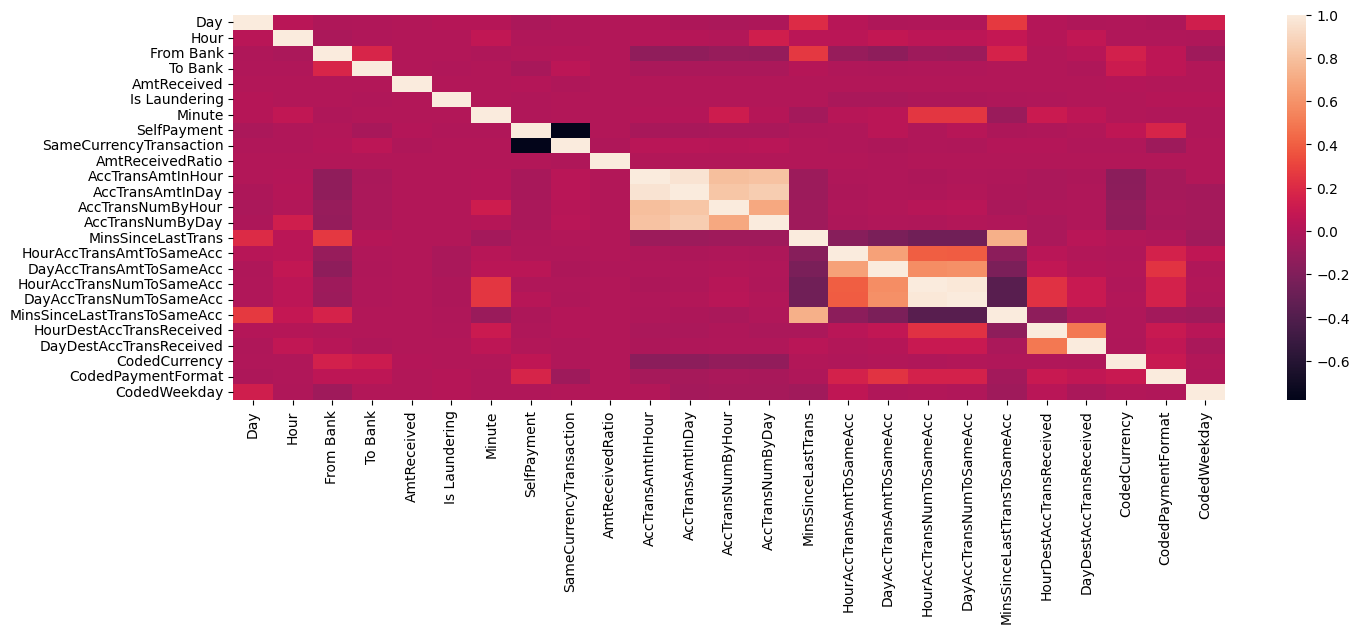

In [50]:
%%skip $skip_feature_viz
plot_correlation_matrix(hi_small_model_input)

### Split and Save

In [51]:
hi_small_train, hi_small_test = hi_small_model_input.randomSplit([0.7, 0.3], seed=42)
hi_medium_train, hi_medium_test = hi_medium_model_input.randomSplit([0.7, 0.3], seed=42)

hi_small_train.write.parquet("data/02_model_input/hi_small_train.parquet")
hi_small_test.write.parquet("data/02_model_input/hi_small_test.parquet")

hi_medium_train.write.parquet("data/02_model_input/hi_medium_train.parquet")
hi_medium_test.write.parquet("data/02_model_input/hi_medium_test.parquet")

# 1. Decision Tree

## Iris Dataset

Even though the objective of the project is to classify the transactions in the IBM Transactions for Anti Money Laundering dataset, a good approach into developing a machine learning algorithm from scratch it to start developing it in a well controlled environment. Therefore, this project will use the Iris dataset to guide the development of a decision tree. This decision allow us to evaluate the implementation of the model in a common dataset which we know that the decision tree should perfom well. Therefore serving as a baseline and sanity check of the model implementation.

The Iris dataset is a traditional dataset used in the machine learning domain to evaluate models. It consists of 3 different types of irises' (Setosa, Versicolour, and Virginica) stored in a 150x4 numpy array. Every type of iris has exactly 50 samples, thus being a well balanced dataset. However, we will constuct a tree focused on binary classification and not multiclass classification, and to do such we remve on the types on the data. The data set data is shown bellow:

<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Iris_dataset_scatterplot.svg" alt="drawing" width="500"/>

> *Image courtesy of [wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)*




In [52]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.target = iris_df.target.astype('int')
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We will split the dataset into two. The first dataset will have the setosa and the versicolor while the second will have the versicolor and virginica. From the data visualization image the former dataset will be linear separable in multiple thus being easier to classify, while the latter is not linear separable thus probabliy more difficult.

- 0 = setosa
- 1 = versicolor
- 2 = virginica

In [53]:
def split_test_val(data, label_col, val_rate = 0.3, seed=41):
  data = data.sample(frac = 1, random_state=seed).reset_index(drop=True)
  split_index = int(np.round(len(data)*(1-val_rate)))
  data_train = data[:split_index]
  data_val = data[split_index:]

  train_X = data_train.drop(labels=label_col, axis=1)
  train_y = data_train[label_col]

  val_X = data_val.drop(labels=label_col, axis=1)
  val_y = data_val[label_col]

  return train_X, train_y, val_X, val_y

iris_easy = iris_df.loc[(iris_df.target == 0 )| (iris_df.target == 1)]
iris_hard = iris_df.loc[(iris_df.target == 1 )| (iris_df.target == 2)]

## The Tree Structure

A tree predictor has the structure of an ordered and rooted tree where each node is either a leaf (if it has zero children) or an internal node (if it has at least two children).

The predictior is usualy defined by a tree T whose internal nodes are tagged with tests and leaves are tagged with labels. A test in an internal node with a funtion over an atribute of the dataset with separate the data into multiple subsets. Since we are implementing a binary tree this function will only split into two subsets.

Therefore, the primary structure of the tree is a node, which might be internal (having a attribute and a test) or a leaf (having a label). For simplicity we build a generic node which can be adapted for whichever case.

In [54]:
class Node:

    def __init__(self, label=None, attribute=None, split_test=None):
        self.label = label
        self.attribute = attribute
        self.split_test = split_test
        self.is_leaf = True
        self.left_child = None
        self.right_child = None

## Building a Binary Tree

We focus on the case of binary trees (all internal nodes have exacly two children) for binary classification. The main idea of building the tree is growing it starting from a single node tree (which is a leaf) that corresponds to the classifier assigning to any data point the label that occurs most frequently in the traning set. The tree is grown by picking a leaf and replacing it with an internal node and two new leaves.

However this description of a binary tree leaves some questions open. How do we select an attribute? How do we select the best threshold to split this attribute? How do we select a node to grow? When do we stop growing the tree? How do we calculate the training error?

### Calculating the Training Error

One step of the tree building process is measuring the error of the constructed tree. Suppose we have grown a tree up to a certain point and built a classifier. We consider the training error as the sum of the contributions of all leaves in the tree.

When a leaf does not contribute to the training error, we say that that leaf is pure. On the other hand leaves that does contribute are impure and thus we focus on measuring the impurity of the tree (the entropy). Additionally, the decision tree may also suffer from overfitting, that usually happens when the tree overgrows the cardinality of the training set. Therefore its important to choose the leaf expension guaranteeing the largest decrease in the training error. Thus making a well informed decision such that the error decreases the largest with the least ammount of growth.




In [55]:
def calculate_entropy(labels, func_type):
  # Get counts of zero and ones as vector
  _, counts = np.unique(labels, return_counts=True)
  # Normalize
  p_vec = counts / len(labels)

  # Calculate proper entropy criterion
  if func_type == 'shannon':
    return -np.sum(p_vec * np.log2(p_vec))
  elif func_type == 'scaled':
    return -np.sum((p_vec/2) * np.log2(p_vec))
  elif func_type == 'gini':
    return 1 - np.sum(np.square(p_vec))

def calculate_information_gain(data, labels, left_labels, right_labels, func_type):
    total_entropy = calculate_entropy(labels, func_type)
    left_entropy = calculate_entropy(left_labels, func_type)
    right_entropy = calculate_entropy(right_labels, func_type)

    left_weighted_entropy = (len(left_labels) / len(labels)) * left_entropy
    right_weighted_entropy = (len(right_labels) / len(right_labels)) * right_entropy
    information_gain = total_entropy - (left_weighted_entropy + right_weighted_entropy)
    return information_gain


### Attribute and Threshold Selection

In [56]:
def select_attribute(data, labels, func_type):
    best_feature = None
    best_threshold = None
    best_information_gain = -np.inf

    for feature in data.columns:
        # Get index of the column
        col_idx = data.columns.get_loc(feature)
        # Get possible values within this feature
        feature_values = data.iloc[:, col_idx]
        # Filter only the unique
        unique_values = np.unique(feature_values)
        # Get possible thresholds
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0

        # Calculate info gain of each threshold
        for threshold in thresholds:
            # Get the possible labels for the left node
            left_labels = labels[data.iloc[:, col_idx] <= threshold]

            # Get the possible labels for the right node
            right_labels = labels[data.iloc[:, col_idx] > threshold]
             # labels[np.where(data.iloc[:, col_idx] > threshold)[0]]

            # Calculate the information gain of the split
            information_gain = calculate_information_gain(data, labels, left_labels, right_labels, func_type)

            # Keep if best
            if information_gain > best_information_gain:
                best_feature = col_idx
                best_threshold = threshold
                best_information_gain = information_gain

    return best_feature, best_threshold

Best Feature: 3
Best Threshold: 1.75


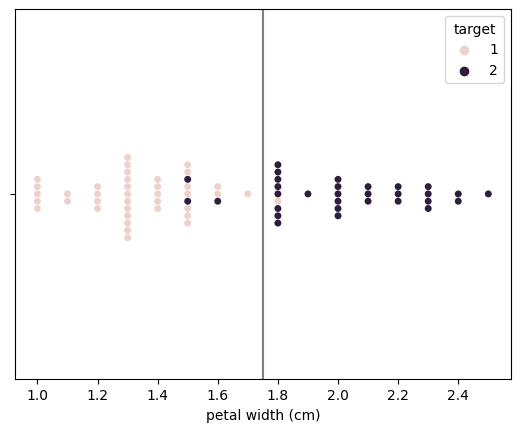

In [57]:
data, labels, _, _ = split_test_val(iris_hard, 'target', val_rate = 0.3)
best_feature, best_treshold = select_attribute(data, labels, 'shannon')

print(f"Best Feature: {best_feature}")
print(f"Best Threshold: {best_treshold}")

data["target"] = labels

sns.swarmplot(data=data, x=data.columns[best_feature], hue="target")
plt.axvline(x=best_treshold, color='grey')

### Stopping Criterias

In [58]:
def max_depth_stop(depth, max_depth):
  return depth==max_depth

def no_labels_to_split_stop(labels):
  return len(np.unique(labels)) == 1

def min_samples_split_stop(labels, min_samples_per_split):
  return len(labels) < min_samples_per_split

### Building the Tree

In [59]:
def build_decision_tree(data, labels, depth=0, max_depth=10, min_samples_per_split=2, func_type='shannon'):
    # Initialize an empty root node
    node = Node()

    if max_depth_stop(depth, max_depth) or no_labels_to_split_stop(labels) or min_samples_split_stop(labels, min_samples_per_split):
        node.label = np.bincount(labels).argmax()
        return node

    # Attribute selection
    best_feature, best_threshold = select_attribute(data, labels, func_type)
    node.attribute = best_feature
    node.split_test = best_threshold
    node.is_leaf = False


    # Split the data to create Sl' and Sl'' based on the selected attribute and threshold
    left_indices = data.iloc[:, best_feature] <= best_threshold
    right_indices = data.iloc[:, best_feature] > best_threshold

    left_data, left_labels = data.loc[left_indices], labels.loc[left_indices]
    right_data, right_labels = data.loc[right_indices], labels.loc[right_indices]

    # Recursively build the left and right subtrees
    if len(left_data) > 0:
        node.left_child = build_decision_tree(left_data, left_labels, depth = depth+1,
                                              max_depth=max_depth, min_samples_per_split=min_samples_per_split, func_type=func_type)
    if len(right_data) > 0:
        node.right_child = build_decision_tree(right_data, right_labels, depth = depth+1,
                                               max_depth=max_depth, min_samples_per_split=min_samples_per_split, func_type=func_type)

    return node


In [60]:
easy_train_X, easy_train_y, easy_test_X, easy_test_y = split_test_val(iris_easy, 'target', val_rate = 0.3)
easy_tree = build_decision_tree(easy_train_X, easy_train_y, max_depth=1)

hard_train_X, hard_train_y, hard_test_X, hard_test_y = split_test_val(iris_hard, 'target', val_rate = 0.3)
hard_tree = build_decision_tree(hard_train_X, hard_train_y, max_depth=10)

#### Viewing Iris Trees

In [61]:
def print_decision_tree(node, columns, indent=""):
    if node.is_leaf:
        print(indent + "Label:", node.label)
        return

    if not node.is_leaf:
        print(indent + columns[node.attribute] + " <= " + str(node.split_test))

    print(indent + "Left:")
    print_decision_tree(node.left_child, columns, indent + "  ")

    print(indent + "Right:")
    print_decision_tree(node.right_child, columns, indent + "  ")

In [62]:
print_decision_tree(hard_tree, hard_train_X.columns)

petal width (cm) <= 1.75
Left:
  sepal length (cm) <= 7.1
  Left:
    sepal width (cm) <= 2.8499999999999996
    Left:
      sepal width (cm) <= 2.25
      Left:
        petal length (cm) <= 4.75
        Left:
          Label: 1
        Right:
          Label: 2
      Right:
        petal width (cm) <= 1.55
        Left:
          petal length (cm) <= 5.0
          Left:
            Label: 1
          Right:
            Label: 2
        Right:
          Label: 1
    Right:
      Label: 1
  Right:
    Label: 2
Right:
  petal length (cm) <= 4.85
  Left:
    sepal length (cm) <= 5.95
    Left:
      Label: 1
    Right:
      Label: 2
  Right:
    Label: 2


## Predict & Error in Iris

In [63]:
def _predict_single(node, instance):
    if node.label is not None:
        return node.label

    if instance[node.attribute] <= node.split_test:
        return _predict_single(node.left_child, instance)
    else:
        return _predict_single(node.right_child, instance)

def predict(root_node, data):
  predictions = [_predict_single(root_node, instance[1]) for instance in data.iterrows()]
  return predictions

def calculate_error(predictions, labels):
    wrong_predictions = np.sum(predictions != labels)
    error = wrong_predictions / len(labels)
    return error

In [64]:
easy_train_preds = predict(easy_tree, easy_train_X)
easy_test_preds = predict(easy_tree, easy_test_X)
error_easy_train = calculate_error(easy_train_preds, easy_train_y)
error_easy_test = calculate_error(easy_test_preds, easy_test_y)

hard_train_preds = predict(hard_tree, hard_train_X)
hard_test_preds = predict(hard_tree, hard_test_X)
error_hard_train = calculate_error(hard_train_preds, hard_train_y)
error_hard_test = calculate_error(hard_test_preds, hard_test_y)

print(f"Linear Separable IRIS Set: Training Error {error_easy_train}; Test Error: {error_easy_test}")
print(f"Non Linear Separable IRIS Set: Training Error {error_hard_train}; Test Error: {error_hard_test}")

Linear Separable IRIS Set: Training Error 0.0; Test Error: 0.0
Non Linear Separable IRIS Set: Training Error 0.0; Test Error: 0.03333333333333333


## The DecisionTree Class

In [65]:
def calculate_error(predictions, labels):
    wrong_predictions = np.sum(predictions != labels)
    error = wrong_predictions / len(labels)
    return error

def accuracy(predictions, labels):
    correct_predictions = np.sum(predictions == labels)
    return correct_predictions / len(labels)

def precision(predictions, labels):
    tp = np.sum((predictions == 1) & (labels == 1))
    fp = np.sum((predictions == 1) & (labels == 0))
    return (tp / (tp + fp))

def recall(predictions, labels):
    tp = np.sum((predictions == 1) & (labels == 1))
    fn = np.sum((predictions == 0) & (labels == 1))
    return tp / (tp + fn)

def specificity(predictions, labels):
    true_negatives = np.sum((predictions == 0) & (labels == 0))
    false_positives = np.sum((predictions == 1) & (labels == 0))
    return true_negatives / (true_negatives + false_positives)

def f1_score(predictions, labels):
    prec = precision(predictions, labels)
    rec = recall(predictions, labels)
    return  2 * (prec * rec) / (prec + rec)

class Node:
    def __init__(self, label=None, attribute=None, split_test=None):
        self.label = label
        self.attribute = attribute
        self.split_test = split_test
        self.is_leaf = True
        self.left_child = None
        self.right_child = None

In [66]:
class DecisionTree:
  def __init__(self, verbose=1, max_depth=10, min_samples_per_split=2, func_type='shannon', tree_id=0,
               threshold_method='all', threshold_buckets=10, class_weights=[], display_metrics='full'):
    self.max_depth = max_depth
    self.min_samples_per_split = min_samples_per_split
    self.func_type = func_type
    self.threshold_method = threshold_method
    self.n_buckets = threshold_buckets
    self.verbose = verbose
    self.class_weights = class_weights
    self.display_metrics = display_metrics
    self.tree_id = tree_id
    self.cols = None
    self.root = None

  def fit(self, data, label):
    self.cols = data.columns
    self.root = self._build_decision_tree(data, label)

    if self.verbose==1:
      preds = self.predict(data, label)

    return self

  def predict(self, data, labels=[]):
    if not self.root:
      raise NotImplementedError("Model not yet fitted.")

    predictions = [self._predict_single(self.root, instance[1]) for instance in data.iterrows()]

    if len(labels):
      DecisionTree.calc_metrics(predictions, labels, self.display_metrics, self.tree_id)

    return predictions


  def print_tree(self, node=None, indent=""):
      if not self.root:
        raise NotImplementedError("Model not yet fitted.")

      if not node:
        node = self.root

      if node.is_leaf:
          print(indent + "Label:", node.label)
          return

      if not node.is_leaf:
          print(indent + self.cols[node.attribute] + " <= " + str(node.split_test))

      print(indent + "Left:")
      self.print_tree(node.left_child, indent + "  ")

      print(indent + "Right:")
      self.print_tree(node.right_child, indent + "  ")

  @staticmethod
  def calc_metrics(preds, label, display_metrics, tree_id=0):
    preds = np.array(preds, dtype='int')
    label = label.to_numpy()
    if display_metrics == 'full':
      print(f"Model Error: {calculate_error(preds, label)}")
      print(f"Model Accuracy: {accuracy(preds, label)}")
      print(f"Model Precision: {precision(preds, label)}")
      print(f"Model Recall: {recall(preds, label)}")
      print(f"Model Specificity: {specificity(preds, label)}")
      print(f"Model F1-Score: {f1_score(preds, label)}")
    if display_metrics == 'random_forest':
      print(f"[Worker {tree_id}] F1-Score: {f1_score(preds, label)}")
      print(f"[Worker {tree_id}] Recall: {recall(preds, label)}")
      print(f"[Worker {tree_id}] Precission: {precision(preds, label)}")

    return preds


  def _calculate_entropy(self, labels):
    # Get counts of zero and ones as vector
    values, counts = np.unique(labels, return_counts=True)

    # Normalize
    p_vec = counts / len(labels)
    if len(self.class_weights) and len(p_vec):
      weights = self.class_weights
      if len(values) == 1:
        weights = self.class_weights[values[0]]
      p_vec = p_vec*weights

    # Calculate proper entropy criterion
    if self.func_type == 'shannon':
      return -np.sum(p_vec * np.log2(p_vec))
    elif self.func_type == 'scaled':
      return -np.sum((p_vec/2) * np.log2(p_vec))
    elif self.func_type == 'gini':
      return 1 - np.sum(np.square(p_vec))

  def _calculate_information_gain(self, data, labels, left_labels, right_labels):
    total_entropy = self._calculate_entropy(labels)
    left_entropy = self._calculate_entropy(left_labels)
    right_entropy = self._calculate_entropy(right_labels)

    left_weighted_entropy = (len(left_labels) / len(labels)) * left_entropy
    right_weighted_entropy = (len(right_labels) / len(labels)) * right_entropy
    information_gain = total_entropy - (left_weighted_entropy + right_weighted_entropy)
    return information_gain

  def _select_attribute(self, data, labels):
    best_feature = None
    best_threshold = None
    best_information_gain = -np.inf

    for feature in data.columns:
        # Get index of the column
        col_idx = data.columns.get_loc(feature)
        # Get possible values within this feature
        feature_values = data.iloc[:, col_idx]
        # Filter only the unique
        thresholds = []
        if self.threshold_method == 'all':
          unique_values = np.unique(feature_values)
          # Get possible thresholds
          thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0
        elif self.threshold_method == 'bigdata':
          thresholds = np.percentile(feature_values, np.linspace(0, 100, self.n_buckets))

        # Calculate info gain of each threshold
        for threshold in thresholds:
            # Get the possible labels for the left node
            left_labels = labels[data.iloc[:, col_idx] <= threshold]

            # Get the possible labels for the right node
            right_labels = labels[data.iloc[:, col_idx] > threshold]
            # labels[np.where(data.iloc[:, col_idx] > threshold)[0]]

            # Calculate the information gain of the split
            information_gain = self._calculate_information_gain(data, labels, left_labels, right_labels)

            # Keep if best
            if information_gain > best_information_gain:
                best_feature = col_idx
                best_threshold = threshold
                best_information_gain = information_gain

    return best_feature, best_threshold

  def _max_depth(self, depth):
    return depth==self.max_depth

  def _no_labels_to_split(self, labels):
    return len(np.unique(labels)) == 1

  def _min_samples_split(self, labels):
    return len(labels) < self.min_samples_per_split

  def _build_decision_tree(self, data, labels, depth=0):
    # Initialize an empty root node
    node = Node()

    if self._max_depth(depth) or self._no_labels_to_split(labels) or self._min_samples_split(labels):
        node.label = np.bincount(labels).argmax()
        return node

    # Attribute selection
    best_feature, best_threshold = self._select_attribute(data, labels)
    node.attribute = best_feature
    node.split_test = best_threshold
    node.is_leaf = False


    # Split the data to create Sl' and Sl'' based on the selected attribute and threshold
    left_indices = data.iloc[:, best_feature] <= best_threshold
    right_indices = data.iloc[:, best_feature] > best_threshold

    left_data, left_labels = data.loc[left_indices], labels.loc[left_indices]
    right_data, right_labels = data.loc[right_indices], labels.loc[right_indices]

    # Recursively build the left and right subtrees
    if len(left_data) > 0:
        node.left_child = self._build_decision_tree(left_data, left_labels, depth = depth+1)
    if len(right_data) > 0:
        node.right_child = self._build_decision_tree(right_data, right_labels, depth = depth+1)

    return node

  def _predict_single(self, node, instance):

    if node.label is not None:
        return node.label

    if instance[node.attribute] <= node.split_test:
        if node.left_child is None:
          print(node.attribute)
          print(node.split_test)
        return self._predict_single(node.left_child, instance)
    else:
        if node.right_child is None:
          print(node.attribute)
          print(node.split_test)
        return self._predict_single(node.right_child, instance)

In [67]:
hard_train_X, hard_train_y, hard_test_X, hard_test_y = split_test_val(iris_hard, 'target', val_rate = 0.3)
hard_train_y[hard_train_y == 2] = 0
hard_test_y[hard_test_y == 2] = 0

clf = DecisionTree()
clf = clf.fit(hard_train_X, hard_train_y)

Model Error: 0.0
Model Accuracy: 1.0
Model Precision: 1.0
Model Recall: 1.0
Model Specificity: 1.0
Model F1-Score: 1.0


In [68]:
preds = clf.predict(hard_test_X, hard_test_y)

Model Error: 0.03333333333333333
Model Accuracy: 0.9666666666666667
Model Precision: 0.9166666666666666
Model Recall: 1.0
Model Specificity: 0.9473684210526315
Model F1-Score: 0.9565217391304348


## IBM AML Decision Tree

In [79]:
hi_small_train = spark.read.parquet('./data/02_model_input/hi_small_train.parquet')
hi_small_train_pandas = hi_small_train.sample(fraction=0.5, seed=42).toPandas()


hi_small_test = spark.read.parquet('./data/02_model_input/hi_small_test.parquet')
hi_small_test_pandas = hi_small_test.sample(fraction=0.5, seed=42).toPandas()

In [70]:
hi_small_train_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609142 entries, 0 to 1609141
Data columns (total 25 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Day                          1609142 non-null  int32  
 1   Hour                         1609142 non-null  int32  
 2   From Bank                    1609142 non-null  int32  
 3   To Bank                      1609142 non-null  int32  
 4   AmtReceived                  1609142 non-null  float32
 5   Is Laundering                1609142 non-null  int32  
 6   Minute                       1609142 non-null  int32  
 7   SelfPayment                  1609142 non-null  int32  
 8   SameCurrencyTransaction      1609142 non-null  int32  
 9   AmtReceivedRatio             1609142 non-null  float64
 10  AccTransAmtInHour            1609142 non-null  int64  
 11  AccTransAmtInDay             1609142 non-null  int64  
 12  AccTransNumByHour            1609142 non-n

In [71]:
label_counts = hi_small_train_pandas["Is Laundering"].value_counts()
hi_class_weights = [1.0, label_counts[0]/label_counts[1]]
print(label_counts)
print(hi_class_weights)

0    1607371
1       1771
Name: Is Laundering, dtype: int64
[1.0, 907.6064370412197]


In [80]:
hi_train_X = hi_small_train_pandas.drop(labels=["Is Laundering"], axis=1)
hi_train_y = hi_small_train_pandas["Is Laundering"]
hi_test_X = hi_small_test_pandas.drop(labels=["Is Laundering"], axis=1)
hi_test_y = hi_small_test_pandas["Is Laundering"]

In [73]:
clf = DecisionTree(max_depth=15, threshold_method='bigdata', threshold_buckets=20, class_weights=hi_class_weights, min_samples_per_split=2)
clf = clf.fit(hi_train_X, hi_train_y)

Model Error: 0.0005058596444564868
Model Accuracy: 0.9994941403555435
Model Precision: 0.9705014749262537
Model Recall: 0.5573122529644269
Model Specificity: 0.9999813359827943
Model F1-Score: 0.7080344332855093


In [74]:
preds = clf.predict(hi_test_X, hi_test_y)

Model Error: 0.0007241360332986713
Model Accuracy: 0.9992758639667013
Model Precision: 0.8132118451025057
Model Recall: 0.46064516129032257
Model Specificity: 0.9998811082451432
Model F1-Score: 0.5881383855024711


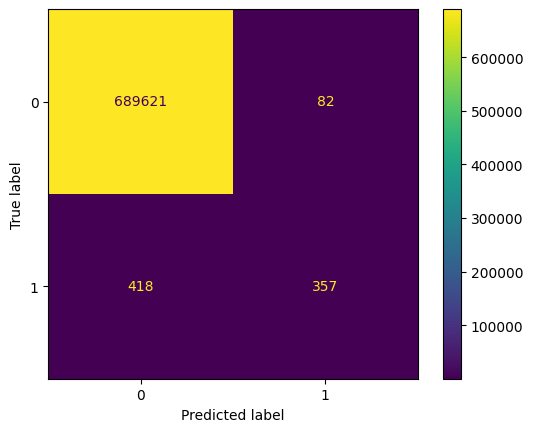

In [75]:
cm = confusion_matrix(hi_test_y, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot();

In [81]:
# Get back the memory
del hi_small_train_pandas, hi_small_test_pandas, hi_train_X, hi_train_y, hi_test_X, hi_test_y

# 2. Distributed Workers

A mock-up code that uses spark in order to consider a dataset and processes it in order to distribute the creation of the single trees in a random forest should be proposed. In particular, the construction of each tree should be done by providing different data to each worker, both subsampling the number of rows (i.e., labeled objects) and columns (i.e., attributes) in the overall dataset. Concerning the first kind of subsampling, you might possibly consider introducing the so-called bootstrap sampling, in which the labeled objects are sampled with replacement and therefore a same object can occur more than once in the resulting dataset. It is not required to distribute the creation of a single decision tree: for this task you are free to use the implementation provided in point 1, as well as the implementation already available in scikit-learn.

In [82]:
spark

In [83]:
for x in spark.sparkContext.getConf().getAll():
  print(f"{x[0].replace('.', ' ').capitalize()}: {x[1]}")

Spark app submittime: 1688289257323
Spark app id: local-1688289260391
Spark sql execution arrow enabled: true
Spark driver port: 36931
Spark app starttime: 1688289257732
Spark executor memory: 4g
Spark app name: MoneyLaundering
Spark executor id: driver
Spark sql warehouse dir: file:/content/spark-warehouse
Spark sql shuffle partitions: 2
Spark driver extrajavaoptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.securi

## Dataset Preparation

### Rows and Features Subsampling

In [84]:
def bootstrap_sample_rows(dataset, seed, sample_ratio=0.3):
   sampled_ds = dataset.sample(withReplacement=True, fraction=sample_ratio, seed=seed)
   return sampled_ds

def sample_columns(dataset, label_col, seed, sample_ratio=0.6):
    # Set random seed
    rng = random.Random(seed)
    # Subtract 1 to exclude the label column
    num_cols = len(dataset.columns) - 1
    # Get column names, except for the label
    features_columns = [col for col in dataset.columns if col != label_col]
    # Shuffle Names
    rng.shuffle(features_columns)
    # Get first %
    selected_cols = features_columns[:int(num_cols * sample_ratio)]
    # Sample the dataset
    sampled_dataset = dataset.select(selected_cols)
    sampled_label = dataset.select(label_col)

    return sampled_dataset, sampled_label

In [85]:
def create_training_data(dataset, ds_params, worker_id):
    # Subsample the dataset using bootstrap sampling
    sampled_ds = bootstrap_sample_rows(dataset, seed=worker_id,
                                       sample_ratio=ds_params["row_frac"])

    # Select a subset of columns for the current tree
    sampled_ds, sampled_label = sample_columns(sampled_ds, ds_params["label"],
                                               seed=worker_id,
                                               sample_ratio=ds_params["col_frac"])

    return sampled_ds, sampled_label

## Train Trees

In [86]:
# Define a function to train a single tree on a worker
def train_tree(worker_id, dataset, tree_params):
    print(f"[Worker {worker_id}] Preparing Data")
    data_X, data_y = dataset

    # Prepare data for training
    data_X = data_X.toPandas()
    data_y = data_y.toPandas().squeeze()

    print(f"[Worker {worker_id}] Creating Tree")
    # Train the tree on the sampled dataset
    tree = DecisionTree(max_depth=tree_params["max_depth"],
                        threshold_method=tree_params["threshold"],
                        threshold_buckets=tree_params["buckets"],
                        min_samples_per_split=tree_params["min_samples_per_split"],
                        tree_id=tree_params["tree_id"],
                        display_metrics=tree_params["disp_mode"]
                        )
    model = tree.fit(data_X, data_y)

    return model

## Predict

In [87]:
def rf_predict(random_forest, data, label_col):

    predictions = []
    for tree in random_forest:
      feature_data, labels = sample_columns(data, label_col, seed=tree, sample_ratio=0.6)

      feature_data = feature_data.toPandas()
      labels = labels.toPandas().squeeze()

      preds = random_forest[tree].predict(feature_data)
      predictions.append(preds)

    predictions = np.array(predictions)
    # Calculate Mode of Tree Predictions
    final_preds = stats.mode(predictions, keepdims=True).mode[0]
    # Print Metrics
    DecisionTree.calc_metrics(final_preds, labels, 'full')
    return final_preds


## Distribute Processing

In [88]:
def distribute_training(dataset, ds_params, tree_params, workers=4):
  # Create a list of worker IDs
  worker_ids = range(workers)

  models = {}
  for worker in worker_ids:
    tree_params["tree_id"] = worker
    worker_data = create_training_data(dataset, ds_params, worker_id=worker)
    tree = train_tree(worker, worker_data, tree_params)
    models[worker] = tree

  return models

In [89]:
def distribute_predict():
  pass


## Small DS Random Forest

In [90]:
hi_small_train = spark.read.parquet('./data/02_model_input/hi_small_train.parquet')
hi_small_test = spark.read.parquet('./data/02_model_input/hi_small_test.parquet')

In [91]:
tree_params = {
    "tree_id": 0,
    "max_depth": 10,
    "threshold": 'bigdata',
    "buckets": 15,
    "min_samples_per_split": 2,
    "disp_mode": "random_forest"
}

ds_params = {
    "label": "Is Laundering",
    "col_frac": 0.5,
    "row_frac": 0.25,
}

num_trees = 5

random_forest = distribute_training(hi_small_train, ds_params, tree_params, workers=num_trees)

[Worker 0] Preparing Data
[Worker 0] Creating Tree
[Worker 0] F1-Score: 0.6071964017991005
[Worker 0] Recall: 0.4623287671232877
[Worker 0] Precission: 0.8842794759825328
[Worker 1] Preparing Data
[Worker 1] Creating Tree
[Worker 1] F1-Score: 0.34986945169712796
[Worker 1] Recall: 0.21405750798722045
[Worker 1] Precission: 0.9571428571428572
[Worker 2] Preparing Data
[Worker 2] Creating Tree
[Worker 2] F1-Score: 0.45076923076923076
[Worker 2] Recall: 0.3259176863181313
[Worker 2] Precission: 0.7306733167082294
[Worker 3] Preparing Data
[Worker 3] Creating Tree
[Worker 3] F1-Score: 0.3541501976284585
[Worker 3] Recall: 0.24060150375939848
[Worker 3] Precission: 0.6706586826347305
[Worker 4] Preparing Data
[Worker 4] Creating Tree
[Worker 4] F1-Score: 0.5623987034035656
[Worker 4] Recall: 0.3961187214611872
[Worker 4] Precission: 0.9692737430167597


In [92]:
final_preds = rf_predict(random_forest, hi_small_test, "Is Laundering")

Model Error: 0.0008175986663284166
Model Accuracy: 0.9991824013336715
Model Precision: 0.9933035714285714
Model Recall: 0.28343949044585987
Model Specificity: 0.9999978230581679
Model F1-Score: 0.4410307234886025


## Medium DS Random Forest